In [ ]:
## using graphviz
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot
## 아래 있는것은 필수는 아닌데, 가끔 에러가 생길 때가 있어서, 그냥 같이 해줌.
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz
import pygraphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 45 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,670 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

1. Graphviz로 결정트리 모델 시각화

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier(random_state=156)

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)

dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=156)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names, feature_names=iris_data.feature_names, impurity=True, filled=True)

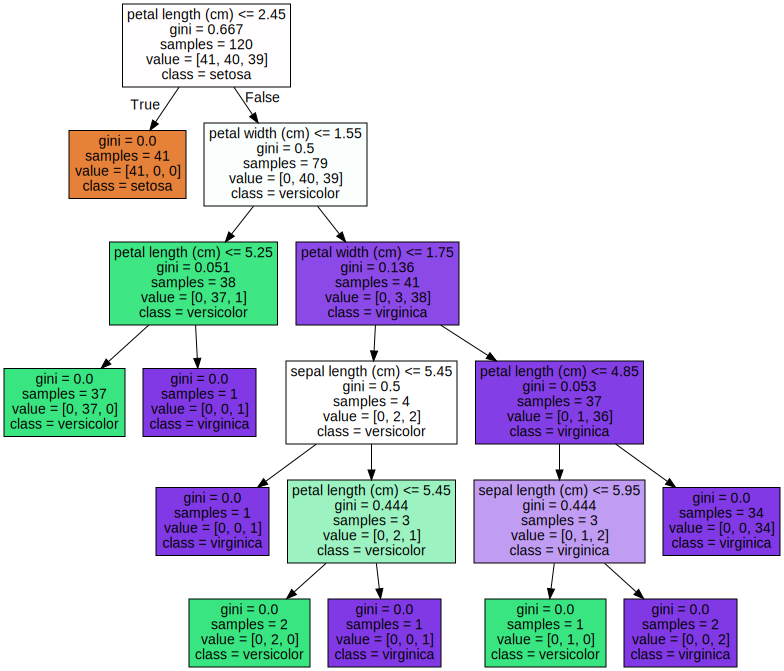

In [ ]:
import graphviz

with open("tree.dot") as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

2. 결정트리의 피처 중요도 확인

Feature importances:
[0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


<Axes: >

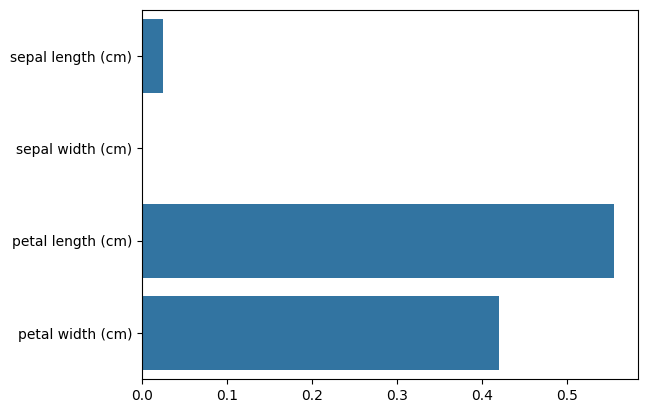

In [ ]:
import seaborn as sns
import numpy as np
%matplotlib inline

print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_,3)))

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
  print('{0} : {1:.3f}'.format(name, value))

sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

3. 앙상블 학습 유형-보팅

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [ ]:
lr_clf=LogisticRegression(solver='liblinear')
knn_clf=KNeighborsClassifier(n_neighbors=8)

vo_clf=VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=15)

vo_clf.fit(X_train,y_train)
pred=vo_clf.predict(X_test)
print('Voting 분류기 정확도:{0:.4f}'.format(accuracy_score(y_test,pred)))

classifiers=[lr_clf,knn_clf]
for classifier in classifiers:
  classifier.fit(X_train,y_train)
  pred=classifier.predict(X_test)
  class_name=classifier.__class__.__name__
  print('{0} 정확도:{1:.4f}'.format(class_name,accuracy_score(y_test,pred)))#꼭 voting 분류가 가장 좋은 것은 아니다.

Voting 분류기 정확도:0.9035
LogisticRegression 정확도:0.8947
KNeighborsClassifier 정확도:0.9123


4. 앙상블 학습 유형-배깅(랜덤 포레스트)

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

params={
    'max_depth':[8,16,24],
    'min_samples_leaf':[1,6,12],
    'min_samples_split':[2,8,16]
}

rf_clf=RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=15)

grid_cv=GridSearchCV(rf_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 8}
최고 예측 정확도:0.9428


In [ ]:
pred=grid_cv.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy))

랜덤 포레스트 정확도:0.9298


 5. 앙상블 학습 유형-부스팅(GBM)

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=15)

start_time=time.time()

gb_clf=GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred=gb_clf.predict(X_test)
gb_accuracy=accuracy_score(y_test,gb_pred)

print('GBM 정확도:{0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간:{0:.1f}초".format(time.time()-start_time))

GBM 정확도:0.9649
GBM 수행 시간:0.9초


6. GBM기반 머신러닝 패키지-XGBoost(파이썬 기반)

In [ ]:
!sudo pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()
features=dataset.data
labels=dataset.target

cancer_df=pd.DataFrame(data=features,columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [ ]:
X_features=cancer_df.iloc[:,:-1]
y_labels=cancer_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)#유방암 데이터셋 중 80%는 학습 용 데이터, 학습용 데이터 중 10%는 검증용으로 분할, 이유는 XGboost의 검증 성능 평가와 조기 중단을 수행하기 위해서.

print(X_train.shape,X_test.shape)
print(X_tr.shape,X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [ ]:
#구버전 XGBoost에서 Dataframe으로 DMatrix가 생성이 안될경우 X_train.values로 넘파이 변환
#학습, 검증, 테스트용 DMatrix를 생성,
dtr=xgb.DMatrix(data=X_tr,label=y_tr)
dval=xgb.DMatrix(data=X_val,label=y_val)
dtest=xgb.DMatrix(data=X_test,label=y_test)

In [ ]:
#XGBoost의 하이퍼 파라미터는 주로 딕셔너리 형태로 입력한다.
params={'max_depth':3,
        'eta':0.05, #학습률 eta
        'objective':'binary:logistic',#예제 데이터가 0또는 1이진 분류이므로 목적함수는 이진 로지스틱
        'eval_metric':'logloss'}#오류 함수의 평가 성능 지표는 logloss
num_rounds=400#부스팅 반복 횟수는 400회

In [ ]:
#학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기한다.
eval_list=[(dtr,'train'),(dval,'eval')] #[(dval,'eval')]만 명기해도 괜찮다.

xgb_model=xgb.train(params=params,dtrain=dtr, num_boost_round=num_rounds,early_stopping_rounds=50,evals=eval_list)

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

In [ ]:
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률값이 0.5 보다 크면 1, 그렇지 않으면 0으로 예측값 설정하여 list인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_test,preds)
print('예측 정확도:{0:.4f}'.format(accuracy))

예측 정확도:0.9649


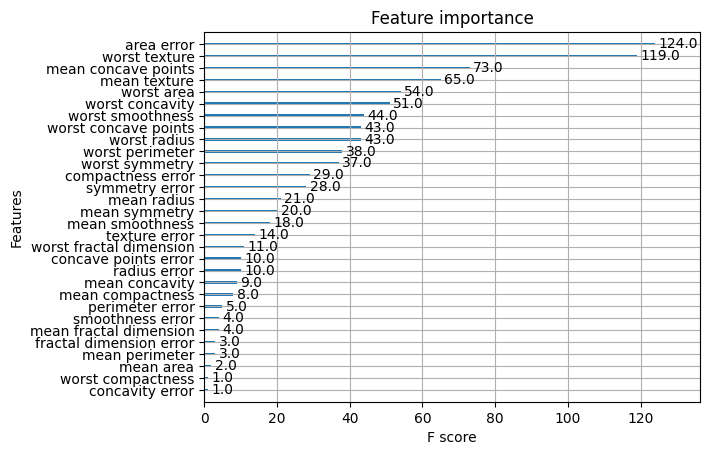

In [ ]:
import graphviz
from xgboost import plot_tree
import matplotlib.pyplot as plt

plot_importance(xgb_model)
plt.show()

7. GBM기반 머신러닝 패키지-XGBoost(사이킷런 래퍼)

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3,eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [ ]:
print(w_preds)

[1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1
 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1
 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1
 1 1 1]


In [ ]:
accuracy=accuracy_score(y_test,w_preds)
print('예측 정확도:{0:.4f}'.format(accuracy))

예측 정확도:0.9737


In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=50, eval_metric="logloss",  verbose=True)
evals=[(X_tr, y_tr),(X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr,  eval_set=evals)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

In [ ]:
accuracy=accuracy_score(y_test,w_preds)
print('예측 정확도:{0:.4f}'.format(accuracy))#데이터 세트가 워낙 작아서 정확도가 검증데이터를 활용하기 전보다 떨어지는 것

예측 정확도:0.9649


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=10, eval_metric="logloss",  verbose=True)
evals=[(X_tr, y_tr),(X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr,  eval_set=evals)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

In [ ]:
accuracy=accuracy_score(y_test,w_preds)
print('예측 정확도:{0:.4f}'.format(accuracy))#너무 조기 중단을 빨리하면 성능이 떨어져야하는데... 왜 안떨어지지...?

예측 정확도:0.9737


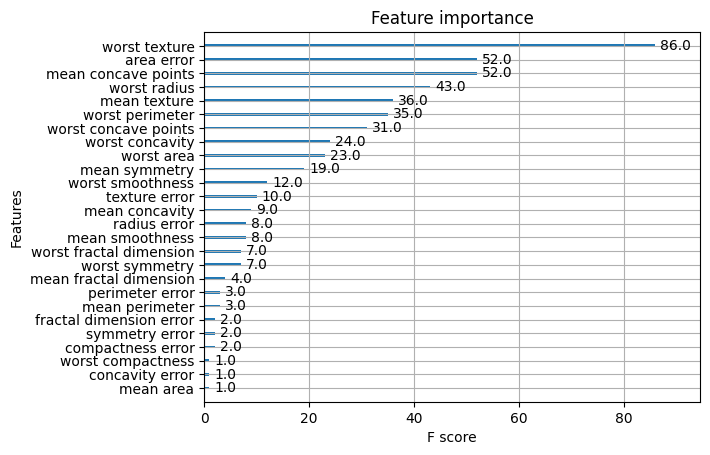

In [ ]:
plot_importance(xgb_wrapper)
plt.show()

8. GBM기반 머신러닝 패키지-LightGBM

In [ ]:
pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.4.0
    Uninstalling lightgbm-4.4.0:
      Successfully uninstalled lightgbm-4.4.0


In [ ]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()

cancer_df=pd.DataFrame(data=dataset.data,columns=dataset.feature_names)
cancer_df['target']=dataset.target
X_features=cancer_df.iloc[:,:-1]
y_labels=cancer_df.iloc[:,-1]

X_train, X_test, y_train, y_test=train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

X_tr, X_val, y_tr, y_val=train_test_split(X_test, y_test, test_size=0.1, random_state=156)

lgbm_wrapper=LGBMClassifier(n_estimators=400, learning_rate=0.05 )

evals=[(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr,  eval_set=evals, eval_metric='logloss', early_stopping_rounds=50,verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[1]	training's binary_logloss: 0.600874	valid_1's binary_logloss: 0.541089
[2]	training's binary_logloss: 0.566805	valid_1's binary_logloss: 0.508516
[3]	training's binary_logloss: 0.538035	valid_1's binary_logloss: 0.47999
[4]	training's binary_logloss: 0.510132	valid_1's binary_logloss: 0.451673
[5]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.425485
[6]	training's binary_logloss: 0.462772	valid_1's binary_logloss: 0.400343
[7]	training's binary_logloss: 0.440564	valid_1's binary_logloss: 0.380358
[8]	training's binary_logloss: 0.419945	valid_1's binary_logloss: 0.362001
[9]	training's binary_logloss: 0.40095	valid_1's binary_logloss: 0.342075
[10]	training's binary_logloss: 0.383222	valid_1's binary_logloss: 0.326364
[11]	training's binary_logloss: 0.366836	valid_1's binary_logloss: 0.30921
[12]	training's binary_logloss: 0.351443	valid_1's binary_logloss: 0.295652
[13]	training's binary_logloss: 0.337146	valid_1's binary_logloss: 0.282982
[14]	training's binary_l

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,preds)
print('예측 정확도:{0:.4f}'.format(accuracy))

예측 정확도:1.0000


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

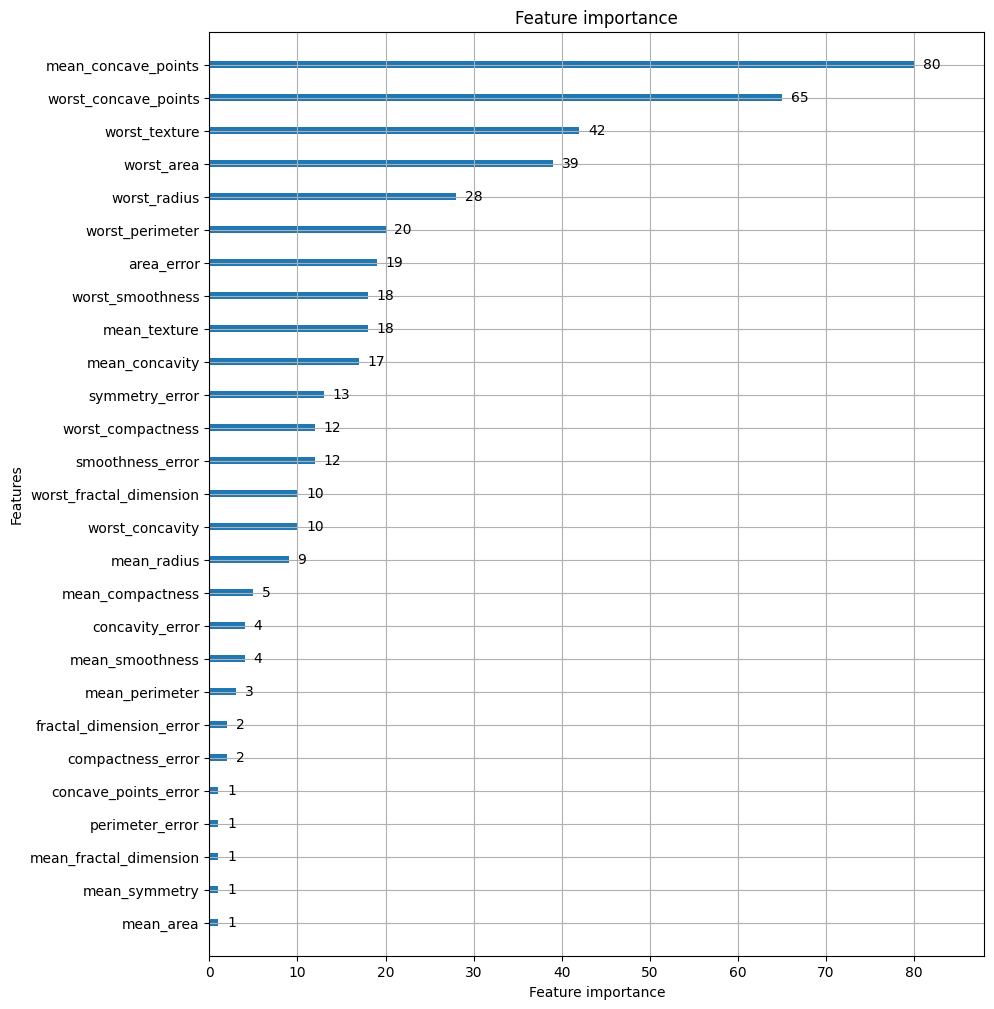

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

9. 베이지안 최적화 개요

In [ ]:
!pip install hyperopt

In [1]:
from hyperopt import hp

search_space= {'x':hp.quniform('x',-10,10,1),'y':hp.quniform('y',-15,15,1)}#검색 공간 설정

In [2]:
search_space

{'x': <hyperopt.pyll.base.Apply at 0x7cfe609b0460>,
 'y': <hyperopt.pyll.base.Apply at 0x7cfe609b08e0>}

In [3]:
from hyperopt import STATUS_OK

def objective_func(search_space):
  x=search_space['x']
  y=search_space['y']
  retval=x**2-20*y
  return retval#return{'loss':retval,'status':STATUS_OK}

In [4]:
from hyperopt import fmin, tpe, Trials#가우시안 최적화를 구현한 TPE
import numpy as np

trial_val=Trials()
best_01=fmin(fn=objective_func,space=search_space,algo=tpe.suggest,max_evals=5,trials=trial_val,rstate=np.random.default_rng(seed=0))#rstate 입력안하면 수행시마다 결과가 다르게 나온다. 근데 고정 안시킬때 좋은 결과가 나오는 경우가 많다.
print('best:',best_01)

100%|██████████| 5/5 [00:00<00:00, 355.42trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [5]:
from hyperopt import fmin, tpe, Trials#가우시안 최적화를 구현한 TPE
import numpy as np

trial_val=Trials()
best_01=fmin(fn=objective_func,space=search_space,algo=tpe.suggest,max_evals=20,trials=trial_val,rstate=np.random.default_rng(seed=0))#rstate 입력안하면 수행시마다 결과가 다르게 나온다. 근데 고정 안시킬때 좋은 결과가 나오는 경우가 많다.
print('best:',best_01)

100%|██████████| 20/20 [00:00<00:00, 303.67trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [6]:
from hyperopt import fmin, tpe, Trials#가우시안 최적화를 구현한 TPE
import numpy as np

trial_val=Trials()
best_01=fmin(fn=objective_func,space=search_space,algo=tpe.suggest,max_evals=50,trials=trial_val,rstate=np.random.default_rng(seed=0))#rstate 입력안하면 수행시마다 결과가 다르게 나온다. 근데 고정 안시킬때 좋은 결과가 나오는 경우가 많다.
print('best:',best_01)

100%|██████████| 50/50 [00:00<00:00, 101.82trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [7]:
trial_val

In [8]:
print(trial_val.results)#Trial 객체의 result속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨, 리스트 내부는 딕셔너리

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}, {'loss': -291.0, 'status': 'ok'}, {'loss': -271.0, 'status': 'ok'}, {'loss': -255.0, 'status': 'ok'}, {'loss': -156.0, 'status': 'ok'}, {'loss': -291.0, 'status': 'ok'}, {'loss': -136.0, 'status': 'ok'}, {'loss': -211.0, 'status': 'ok'}, {'loss': -176.0, 'status': 'ok'}, {'loss': -95.0, 'status': 'ok'}, {'loss': -264.0, 'status': 'ok'}, {'lo

In [10]:
print(trial_val.vals)#입력 변수의 값이 저장된다. 딕셔너리 형태로 저장된다.

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0, 3.0, 3.0, 5.0, -2.0, 3.0, -2.0, 7.0, 2.0, 5.0, -6.0, 7.0, 4.0, -1.0, -5.0, 2.0, 4.0, -3.0, 1.0, -8.0, 6.0, 8.0, -1.0, 10.0, 1.0, 3.0, 5.0, -1.0, -10.0, -5.0, 6.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0, 15.0, 14.0, 14.0, 8.0, 15.0, 7.0, 13.0, 9.0, 6.0, 15.0, 5.0, -15.0, 12.0, 10.0, -2.0, -12.0, 12.0, -6.0, 8.0, 15.0, 12.0, -4.0, 6.0, -1.0, -9.0, 2.0, 10.0, 14.0, -7.0, -11.0]}


In [11]:
import pandas as pd#보기 편하게 만들어 보면....

losses=[loss_dict['loss'] for loss_dict in trial_val.results]
result_df=pd.DataFrame({'x':trial_val.vals['x'],'y':trial_val.vals['y'],'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


10. hyperOpt를 XGBoost하이퍼 파라미터 튜닝에 적용

In [37]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()


cancer_df=pd.DataFrame(data=dataset.data,columns=dataset.feature_names)
cancer_df['target']=dataset.target
X_features=cancer_df.iloc[:,:-1]
y_labels=cancer_df.iloc[:,-1]

X_train, X_test, y_train, y_test=train_test_split(X_features, y_labels, test_size=0.2, random_state=156)
X_tr, X_val, y_tr, y_val=train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [38]:
from hyperopt import hp
#검색 공간 설정
xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}


In [39]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK
#모든 입력값은 실수로 들어온다. 여러 변수들은 정수형으로 들어오는게 필요하다.

def objective_func(search_space):

    xgb_clf = XGBClassifier(
        n_estimators=100,
        max_depth=int(search_space['max_depth']),
        min_child_weight=int(search_space['min_child_weight']),
        learning_rate=search_space['learning_rate'],
        colsample_bytree=search_space['colsample_bytree'],
        eval_metric='logloss'
    )
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    return {'loss': -1 * np.mean(accuracy), 'status': STATUS_OK}


In [42]:
from hyperopt import fmin, tpe, Trials
import numpy as np

trial_val=Trials()
best=fmin(fn=objective_func,
          space=xgb_search_space,
          algo=tpe.suggest,
          max_evals=50,
          trials=trial_val,rstate=np.random.default_rng(seed=9))
print('best:',best)

100%|██████████| 50/50 [00:19<00:00,  2.51trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5026505409854508, 'learning_rate': 0.19828428817109603, 'max_depth': 15.0, 'min_child_weight': 1.0}


11. 베이직 스태킹 모델

In [43]:
#데이터 로딩
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test=train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [44]:
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

#최종 스테킹 모델을 위한 Classifier 생성.
lr_final=LogisticRegression(C=10)

In [45]:
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)
#개별모델 학습

AdaBoostClassifier(n_estimators=100)

In [46]:
#개별 예측 데이터셋 생성
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print(accuracy_score(y_test, knn_pred))
print(accuracy_score(y_test, rf_pred))
print(accuracy_score(y_test, dt_pred))
print(accuracy_score(y_test, ada_pred))

0.9210526315789473
0.9649122807017544
0.9035087719298246
0.956140350877193


In [47]:
#개별 모델의 예측 결과를 메타 모델이 학습할 수 있게 스태킹 형태로 재 생성

pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

pred=np.transpose(pred)
print(pred.shape)#각각의 모델이 열차원이 되어야한다.

(4, 114)
(114, 4)


In [48]:
#메타 모델 학습/예측/평가
lr_final.fit(pred,y_test)
final=lr_final.predict(pred)

print(accuracy_score(y_test,final))

0.9736842105263158


12. 교차 검증 세트 기반의 스태킹(반드시 다 알필요는 없다.)

In [57]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  kf=KFold(n_splits=n_folds,shuffle=False)

  train_fold_pred=np.zeros((X_train_n.shape[0],1))#2차원 데이터
  test_pred=np.zeros((X_test_n.shape[0],n_folds))#n fold만큼의 수만큼 만든다.
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    print('\t 폴드 세트:',folder_counter,'시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]

    model.fit(X_tr,y_tr)
    train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter]=model.predict(X_test_n)

  test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)

  return train_fold_pred, test_pred_mean

In [58]:
knn_train,knn_test=get_stacking_base_datasets(knn_clf,X_train,y_train,X_test,7)
rf_train,rf_test=get_stacking_base_datasets(rf_clf,X_train,y_train,X_test,7)
dt_train,dt_test=get_stacking_base_datasets(dt_clf,X_train,y_train,X_test,7)
ada_train,ada_test=get_stacking_base_datasets(ada_clf,X_train,y_train,X_test,7)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


In [59]:
Stack_final_X_train=np.concatenate((knn_train,rf_train,dt_train,ada_train),axis=1)
Stack_final_X_test=np.concatenate((knn_test,rf_test,dt_test,ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape,'원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,'스태킹 테스트 피처 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 Shape: (114, 4)


In [60]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final=lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도:0.9737
